In [29]:
import tensorflow as tf

import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

Definimos funciones que nos seran utiles posteriormente

In [30]:
def get_n_similar(indexes, n):
  sorted_counts = sorted(indexes.items(), key=lambda x:x[1], reverse=True)[:n]
  sorted_indexes = [int(float(tupl[0])) for tupl in sorted_counts]
  return sorted_indexes

def display_n_similar(indexes, n):
    if n <= 0:
        print("El valor de n debe ser mayor que 0.")
        return

    if n > len(indexes):
        print(f"Solo hay {len(indexes)} imágenes en la lista. Mostrando todas.")
        n = len(indexes)
    sorted_indexes = get_n_similar(indexes, n)
    fig, axs = plt.subplots(1, n, figsize=(15,15))
    for i in range(n):
        idx = sorted_indexes[i]
        im = cv2.cvtColor(cv2.imread(f'n04487081_{str(idx)}.JPEG'), cv2.COLOR_BGR2RGB)
        axs[i].imshow(im)
        axs[i].axis('off')

    plt.show()

Para este proyecto vamos a usar un subconjunto de imagenes de imagenet

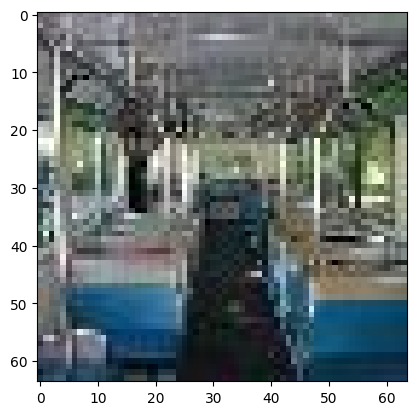

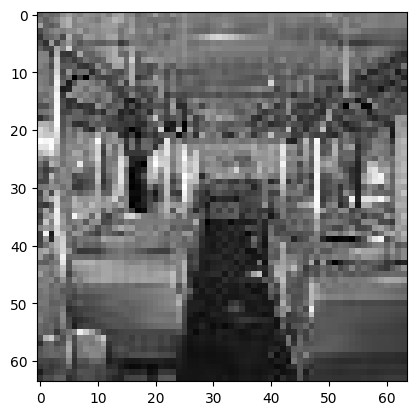

In [31]:
im1 = cv2.imread('n04487081_0.JPEG')
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
plt.imshow(im1)
plt.show()
gray_im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_im1, cmap='gray')
plt.show()

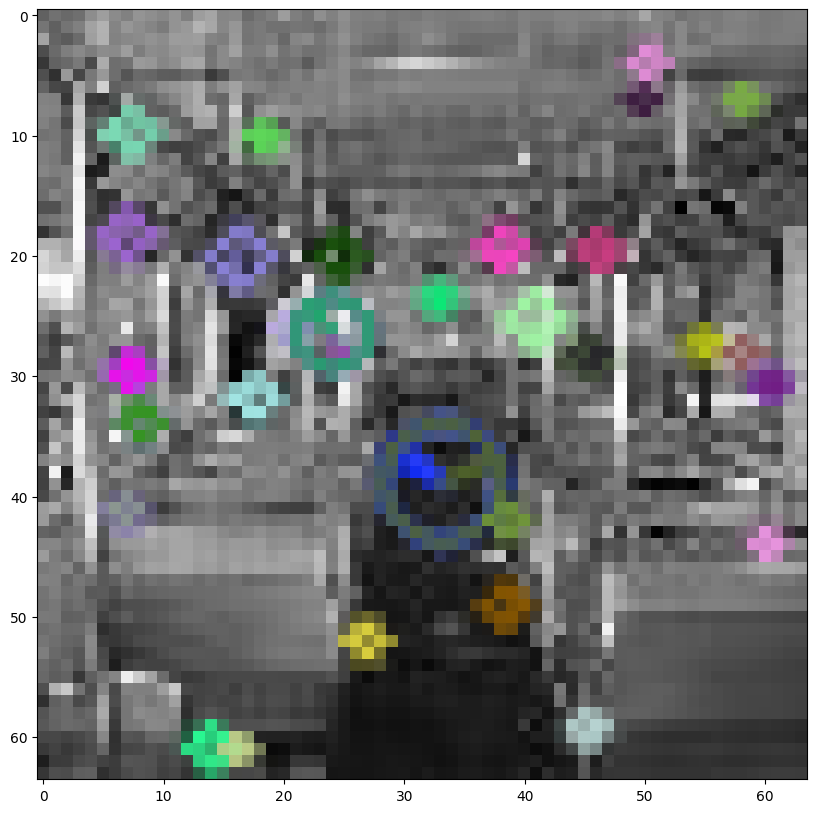

In [32]:
sift = cv2.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(gray_im1, mask=None)
im1_sift = cv2.drawKeypoints(gray_im1, keypoints_1, im1, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(10,10))
plt.imshow(im1_sift)
plt.show()

creamos una matriz numpy donde almacenaremos todos los descriptores con la etiqueta de la imagen a la q pertenecen

In [33]:
sift = cv2.SIFT_create()
descriptors = np.empty((0,129))
for i in range(0, 100):
  gray_im = cv2.cvtColor(cv2.imread(f'n04487081_{i}.JPEG'), cv2.COLOR_BGR2GRAY)
  _ , descriptor = sift.detectAndCompute(gray_im, mask=None)

  descriptors_arr = np.array(descriptor)
  descriptors_arr = np.insert(descriptors_arr, 0, str(i), axis=1)
  descriptors =  np.vstack([descriptors, descriptors_arr])



In [34]:
descriptors.shape

(3821, 129)

Entrenamos knn

In [35]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=5, algorithm='auto', metric='euclidean')

descriptors_train = descriptors[:, 1:]
knn.fit(descriptors_train)

NearestNeighbors(metric='euclidean', n_neighbors=100)

La estrategia para determinar las imagenes mas similares sera la siguiente:

1.- Obtenemos para cada descriptor de la imagen nueva sus 5 descriptores mas cercanos.

2.- Obtenemos los ID de las imagenes a las que pertenecen dichos descriptores.

3.- Almacenamos en un diccionario el numero de veces que aparece un descriptor de cada imagen.

4.- Recuperamos las n imagenes con mayor numero de descriptores coincidentes con los de la imagen nueva.

In [36]:
counts = {}
new_img = cv2.cvtColor(cv2.imread('n04487081_95.JPEG'), cv2.COLOR_BGR2GRAY)
_ , descriptor = sift.detectAndCompute(new_img, mask=None)
descriptors_arr = np.array(descriptor)
for descriptor_i in descriptor:
  descriptor_i = descriptor_i.reshape(1, -1)
  distance, indice = knn.kneighbors(descriptor_i, n_neighbors=5)
  for idx in indice[0]:
    id = str(descriptors[idx,0])
    if id in counts:
      counts[id] += 1
    else:
      counts[id] = 1

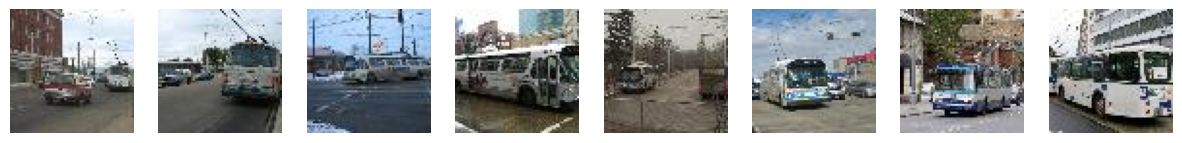

In [37]:
display_n_similar(counts, 8)